In [1]:
"""
Comparative Analysis: Natural Gradient vs Standard Gradient for LightGBMLSS

This script provides detailed analysis and visualization of the differences between
natural gradient and standard gradient training for Gaussian distribution.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import lightgbm as lgb
import time

import sys
import os
sys.path.append(os.path.abspath('..'))
from lightgbmlss.model import *
from lightgbmlss.distributions.Gaussian import Gaussian

NATURAL GRADIENT vs STANDARD GRADIENT COMPARISON

🚀 Training with Natural Gradient...

🚀 Training with Standard Gradient...

RESULTS SUMMARY

⏱️  Training Time:
   Natural Gradient: 0.47s
   Standard Gradient: 0.42s
   Speedup: 0.90x

📊 Test Set Performance (NLL):
   Natural Gradient: 2.6312
   Standard Gradient: 2.6701
   Improvement: 1.46%

📈 Mean Parameter MAE:
   Natural Gradient: 0.5024
   Standard Gradient: 0.5130
   Improvement: 2.06%

📈 Std Parameter MAE:
   Natural Gradient: 0.6752
   Standard Gradient: 0.6660
   Improvement: -1.39%

📊 Visualization saved as 'natural_gradient_comparison.png'


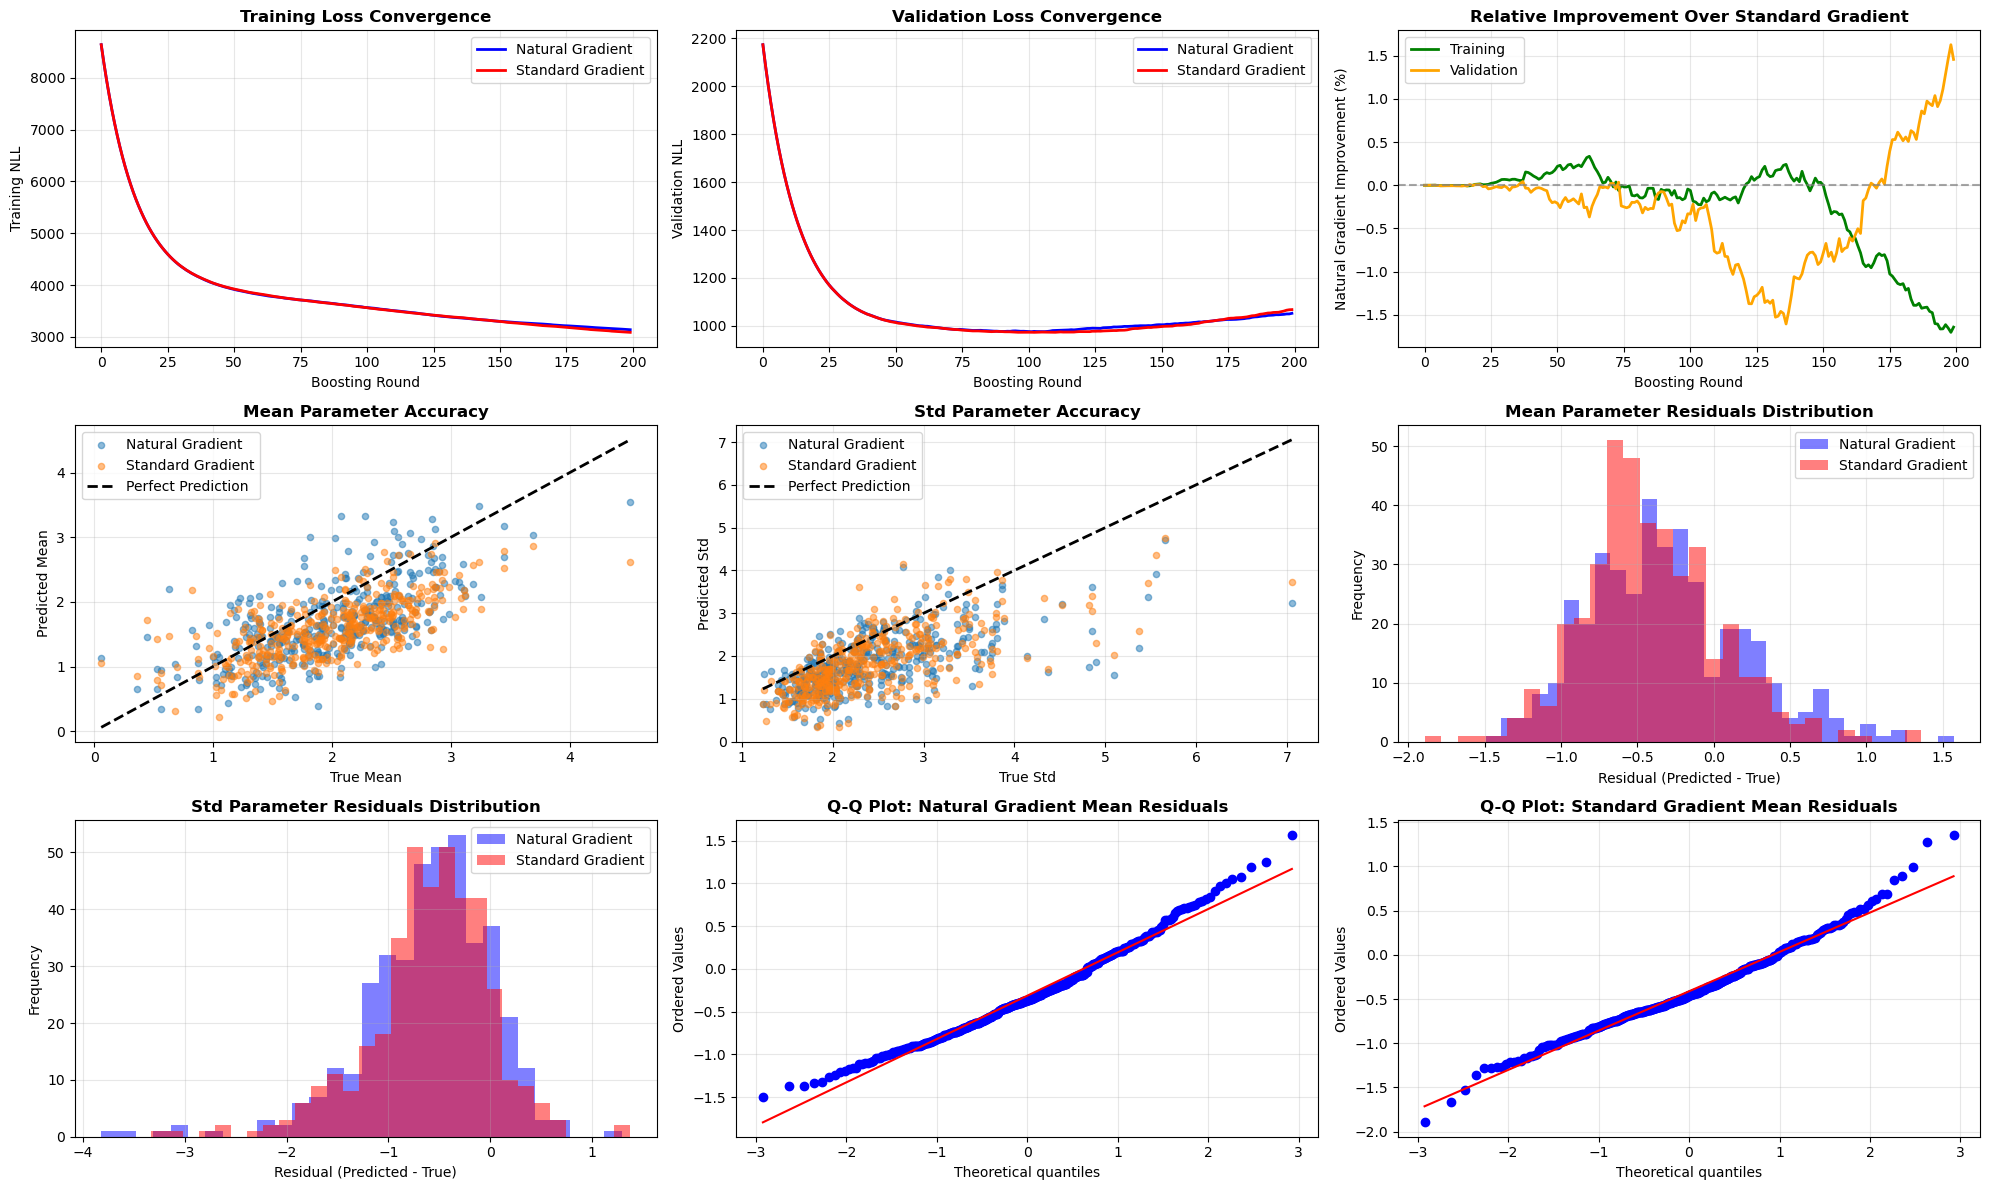

In [4]:
def generate_heteroscedastic_data(n_samples=2000, n_features=10, seed=42):
    """
    Generate synthetic heteroscedastic Gaussian data.
    """
    np.random.seed(seed)
    
    # Generate features
    X = np.random.randn(n_samples, n_features)
    
    # Complex mean function
    mu = (2.0 + 0.5 * X[:, 0] - 0.3 * X[:, 1] + 0.2 * X[:, 2] + 
          0.15 * X[:, 3] * X[:, 4] + 0.1 * np.sin(X[:, 5]))
    
    # Heteroscedastic variance
    sigma = np.exp(0.5 + 0.3 * np.abs(X[:, 6]) + 0.2 * X[:, 7] + 
                   0.1 * (X[:, 8] ** 2))
    
    # Sample from Gaussian
    y = mu + sigma * np.random.randn(n_samples)
    
    X_df = pd.DataFrame(X, columns=[f'x{i}' for i in range(n_features)])
    
    return X_df, np.array(y), np.array(mu), np.array(sigma)


def compare_gradient_methods():
    """
    Comprehensive comparison of Natural Gradient vs Standard Gradient.
    """
    print("="*80)
    print("NATURAL GRADIENT vs STANDARD GRADIENT COMPARISON")
    print("="*80)
    
    # Generate data
    X, y, true_mu, true_sigma = generate_heteroscedastic_data(n_samples=2000)
    
    # Split data
    split_idx = int(0.8 * len(y))
    X_train, X_test = X.iloc[:split_idx].copy(), X.iloc[split_idx:].copy()
    y_train, y_test = y[:split_idx].copy(), y[split_idx:].copy()
    mu_test, sigma_test = true_mu[split_idx:].copy(), true_sigma[split_idx:].copy()
    
    # Ensure proper numpy array types
    y_train = np.asarray(y_train, dtype=np.float64)
    y_test = np.asarray(y_test, dtype=np.float64)
    
    # Training parameters
    params = {
        "learning_rate": 0.05,
        "max_depth": 5,
        "num_leaves": 31,
        "min_data_in_leaf": 20,
        "feature_pre_filter": False,
        "verbose": -1
    }
    
    num_rounds = 200
    
    # Train with Natural Gradient
    print("\n🚀 Training with Natural Gradient...")
    start_time = time.time()
    
    gauss_nat = Gaussian(stabilization="MAD", response_fn="softplus", 
                        loss_fn="nll", natural_gradient=True)
    lgblss_nat = LightGBMLSS(gauss_nat)
    lgblss_nat.start_values = np.array([np.array(0.5) for _ in range(lgblss_nat.dist.n_dist_param)])
    
    # Create datasets for natural gradient
    dtrain_nat = lgb.Dataset(X_train, label=y_train)
    dvalid_nat = lgb.Dataset(X_test, label=y_test, reference=dtrain_nat)
    
    eval_results_nat = {}
    lgblss_nat.train(
        params, dtrain_nat, num_boost_round=num_rounds,
        valid_sets=[dtrain_nat, dvalid_nat],
        valid_names=['train', 'valid'],
        callbacks=[lgb.record_evaluation(eval_results_nat)]
    )
    
    time_nat = time.time() - start_time
    
    # Train with Standard Gradient
    print("\n🚀 Training with Standard Gradient...")
    start_time = time.time()
    
    gauss_std = Gaussian(stabilization="MAD", response_fn="softplus", 
                        loss_fn="nll", natural_gradient=False)
    lgblss_std = LightGBMLSS(gauss_std)
    # FIX: Set initial values for standard gradient too
    lgblss_std.start_values = np.array([np.array(0.5) for _ in range(lgblss_std.dist.n_dist_param)])
    
    # Create new datasets for standard gradient
    dtrain_std = lgb.Dataset(X_train, label=y_train)
    dvalid_std = lgb.Dataset(X_test, label=y_test, reference=dtrain_std)
    
    eval_results_std = {}
    lgblss_std.train(
        params, dtrain_std, num_boost_round=num_rounds,
        valid_sets=[dtrain_std, dvalid_std],
        valid_names=['train', 'valid'],
        callbacks=[lgb.record_evaluation(eval_results_std)]
    )
    time_std = time.time() - start_time
    
    # Make predictions
    pred_nat = lgblss_nat.predict(X_test)
    pred_std = lgblss_std.predict(X_test)
    
    # Calculate metrics
    nll_nat = -np.mean(stats.norm.logpdf(y_test, loc=pred_nat['loc'], scale=pred_nat['scale']))
    nll_std = -np.mean(stats.norm.logpdf(y_test, loc=pred_std['loc'], scale=pred_std['scale']))
    
    mae_mu_nat = np.mean(np.abs(pred_nat['loc'] - mu_test))
    mae_mu_std = np.mean(np.abs(pred_std['loc'] - mu_test))
    
    mae_sigma_nat = np.mean(np.abs(pred_nat['scale'] - sigma_test))
    mae_sigma_std = np.mean(np.abs(pred_std['scale'] - sigma_test))
    
    # Print results
    print("\n" + "="*80)
    print("RESULTS SUMMARY")
    print("="*80)
    print(f"\n⏱️  Training Time:")
    print(f"   Natural Gradient: {time_nat:.2f}s")
    print(f"   Standard Gradient: {time_std:.2f}s")
    print(f"   Speedup: {time_std/time_nat:.2f}x")
    
    print(f"\n📊 Test Set Performance (NLL):")
    print(f"   Natural Gradient: {nll_nat:.4f}")
    print(f"   Standard Gradient: {nll_std:.4f}")
    print(f"   Improvement: {((nll_std - nll_nat)/nll_std)*100:.2f}%")
    
    print(f"\n📈 Mean Parameter MAE:")
    print(f"   Natural Gradient: {mae_mu_nat:.4f}")
    print(f"   Standard Gradient: {mae_mu_std:.4f}")
    print(f"   Improvement: {((mae_mu_std - mae_mu_nat)/mae_mu_std)*100:.2f}%")
    
    print(f"\n📈 Std Parameter MAE:")
    print(f"   Natural Gradient: {mae_sigma_nat:.4f}")
    print(f"   Standard Gradient: {mae_sigma_std:.4f}")
    print(f"   Improvement: {((mae_sigma_std - mae_sigma_nat)/mae_sigma_std)*100:.2f}%")
    
    # Visualization
    fig = plt.figure(figsize=(20, 12))
    
    # Plot 1: Training Loss Convergence
    ax1 = plt.subplot(3, 3, 1)
    train_loss_nat = eval_results_nat['train']['nll']
    train_loss_std = eval_results_std['train']['nll']
    
    plt.plot(train_loss_nat, label='Natural Gradient', linewidth=2, color='blue')
    plt.plot(train_loss_std, label='Standard Gradient', linewidth=2, color='red')
    plt.xlabel('Boosting Round')
    plt.ylabel('Training NLL')
    plt.title('Training Loss Convergence', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Validation Loss Convergence
    ax2 = plt.subplot(3, 3, 2)
    valid_loss_nat = eval_results_nat['valid']['nll']
    valid_loss_std = eval_results_std['valid']['nll']
    
    plt.plot(valid_loss_nat, label='Natural Gradient', linewidth=2, color='blue')
    plt.plot(valid_loss_std, label='Standard Gradient', linewidth=2, color='red')
    plt.xlabel('Boosting Round')
    plt.ylabel('Validation NLL')
    plt.title('Validation Loss Convergence', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Loss Improvement over Iterations
    ax3 = plt.subplot(3, 3, 3)
    improvement_train = ((np.array(train_loss_std) - np.array(train_loss_nat)) / 
                        np.array(train_loss_std)) * 100
    improvement_valid = ((np.array(valid_loss_std) - np.array(valid_loss_nat)) / 
                        np.array(valid_loss_std)) * 100
    
    plt.plot(improvement_train, label='Training', linewidth=2, color='green')
    plt.plot(improvement_valid, label='Validation', linewidth=2, color='orange')
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    plt.xlabel('Boosting Round')
    plt.ylabel('Natural Gradient Improvement (%)')
    plt.title('Relative Improvement Over Standard Gradient', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Mean Parameter Predictions
    ax4 = plt.subplot(3, 3, 4)
    plt.scatter(mu_test, pred_nat['loc'], alpha=0.5, label='Natural Gradient', s=20)
    plt.scatter(mu_test, pred_std['loc'], alpha=0.5, label='Standard Gradient', s=20)
    plt.plot([mu_test.min(), mu_test.max()], [mu_test.min(), mu_test.max()], 
             'k--', linewidth=2, label='Perfect Prediction')
    plt.xlabel('True Mean')
    plt.ylabel('Predicted Mean')
    plt.title('Mean Parameter Accuracy', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Std Parameter Predictions
    ax5 = plt.subplot(3, 3, 5)
    plt.scatter(sigma_test, pred_nat['scale'], alpha=0.5, label='Natural Gradient', s=20)
    plt.scatter(sigma_test, pred_std['scale'], alpha=0.5, label='Standard Gradient', s=20)
    plt.plot([sigma_test.min(), sigma_test.max()], [sigma_test.min(), sigma_test.max()], 
             'k--', linewidth=2, label='Perfect Prediction')
    plt.xlabel('True Std')
    plt.ylabel('Predicted Std')
    plt.title('Std Parameter Accuracy', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Residuals for Mean
    ax6 = plt.subplot(3, 3, 6)
    resid_mu_nat = pred_nat['loc'] - mu_test
    resid_mu_std = pred_std['loc'] - mu_test
    
    plt.hist(resid_mu_nat, bins=30, alpha=0.5, label='Natural Gradient', color='blue')
    plt.hist(resid_mu_std, bins=30, alpha=0.5, label='Standard Gradient', color='red')
    plt.xlabel('Residual (Predicted - True)')
    plt.ylabel('Frequency')
    plt.title('Mean Parameter Residuals Distribution', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 7: Residuals for Std
    ax7 = plt.subplot(3, 3, 7)
    resid_sigma_nat = pred_nat['scale'] - sigma_test
    resid_sigma_std = pred_std['scale'] - sigma_test
    
    plt.hist(resid_sigma_nat, bins=30, alpha=0.5, label='Natural Gradient', color='blue')
    plt.hist(resid_sigma_std, bins=30, alpha=0.5, label='Standard Gradient', color='red')
    plt.xlabel('Residual (Predicted - True)')
    plt.ylabel('Frequency')
    plt.title('Std Parameter Residuals Distribution', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 8: Quantile-Quantile Plots
    ax8 = plt.subplot(3, 3, 8)
    stats.probplot(resid_mu_nat, dist="norm", plot=plt)
    plt.title('Q-Q Plot: Natural Gradient Mean Residuals', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    ax9 = plt.subplot(3, 3, 9)
    stats.probplot(resid_mu_std, dist="norm", plot=plt)
    plt.title('Q-Q Plot: Standard Gradient Mean Residuals', fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('natural_gradient_comparison.png', dpi=300, bbox_inches='tight')
    print("\n📊 Visualization saved as 'natural_gradient_comparison.png'")
    plt.show()
    
    return {
        'time_nat': time_nat,
        'time_std': time_std,
        'nll_nat': nll_nat,
        'nll_std': nll_std,
        'mae_mu_nat': mae_mu_nat,
        'mae_mu_std': mae_mu_std,
        'mae_sigma_nat': mae_sigma_nat,
        'mae_sigma_std': mae_sigma_std,
    }


if __name__ == "__main__":
    results = compare_gradient_methods()

In [23]:
# Generate data
X, y, true_mu, true_sigma = generate_heteroscedastic_data(n_samples=2000)

# Split data
split_idx = int(0.8 * len(y))
X_train, X_test = X.iloc[:split_idx].copy(), X.iloc[split_idx:].copy()
y_train, y_test = y[:split_idx].copy(), y[split_idx:].copy()
mu_test, sigma_test = true_mu[split_idx:].copy(), true_sigma[split_idx:].copy()

# Ensure proper numpy array types
y_train = np.asarray(y_train, dtype=np.float64)
y_test = np.asarray(y_test, dtype=np.float64)

# Training parameters
params = {
    "learning_rate": 0.05,
    "max_depth": 5,
    "num_leaves": 31,
    "min_data_in_leaf": 20,
    "feature_pre_filter": False,
    "verbose": -1
}

num_rounds = 200

# Train with Natural Gradient
print("\n🚀 Training with Natural Gradient...")
start_time = time.time()

gauss_nat = Gaussian(stabilization="MAD", response_fn="softplus", 
                    loss_fn="nll", natural_gradient=True)
lgblss_nat = LightGBMLSS(gauss_nat)
lgblss_nat.start_values = np.array([np.array(0.5) for _ in range(lgblss_nat.dist.n_dist_param)])

# Create datasets for natural gradient
dtrain_nat = lgb.Dataset(X_train, label=y_train)
dvalid_nat = lgb.Dataset(X_test, label=y_test, reference=dtrain_nat)


🚀 Training with Natural Gradient...


In [24]:
eval_results_nat = {}
lgblss_nat.train(
    params, dtrain_nat, num_boost_round=num_rounds,
    valid_sets=[dtrain_nat, dvalid_nat],
    valid_names=['train', 'valid'],
    callbacks=[lgb.record_evaluation(eval_results_nat)]
)

RuntimeError: Could not infer dtype of numpy.float32

In [18]:
X_train

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,1.579213,0.767435,-0.469474,0.542560
1,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,-0.562288,-1.012831,0.314247,-0.908024,-1.412304
2,1.465649,-0.225776,0.067528,-1.424748,-0.544383,0.110923,-1.150994,0.375698,-0.600639,-0.291694
3,-0.601707,1.852278,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,-1.328186,0.196861
4,0.738467,0.171368,-0.115648,-0.301104,-1.478522,-0.719844,-0.460639,1.057122,0.343618,-1.763040
...,...,...,...,...,...,...,...,...,...,...
1595,0.259479,0.018796,-0.855533,1.179538,0.517275,0.629238,-0.507531,0.834101,0.911814,-0.668778
1596,-1.416990,0.581373,-1.573347,0.152016,-0.447245,1.218665,-0.392844,1.107273,-0.514209,0.999991
1597,2.060342,-1.068047,0.292036,2.748782,0.066589,0.061788,0.788499,0.041081,-1.707226,1.132287
1598,-2.002948,-0.416792,1.207426,-0.356542,-0.693696,0.879264,-0.851115,-1.222226,0.274514,-0.182923


In [19]:
y_train

array([ 3.44185635,  3.13009772,  0.50407881, ...,  3.88152208,
        3.13229456, -1.74909888])

## Test Suite for Natural Gradient

A comprehensive test suite has been created at `tests/test_natural_gradient/test_natural_gradient_gaussian.py` that validates:

1.**Initialization**: Natural gradient flag is properly set
2.**Training**: LightGBMLSS trains successfully with natural gradients
3.**Comparison**: Natural vs standard gradients produce different results
4.**Convergence**: Loss decreases over iterations
5.**Parameter Estimation**: Predictions correlate with true parameters
6.**Start Values**: Notebook syntax for setting initial values works
7.**Dataset Creation**: LightGBM dataset creation matches notebook usage
8.**Prediction Format**: Output format matches expected structure (dict with 'loc' and 'scale')

### Run Tests

```bash
# From LightGBMLSS directory
cd /Users/evgenygenov/Yandex.Disk.localized/GitHub/LSSboost_test/LightGBMLSS
pytest tests/test_natural_gradient/test_natural_gradient_gaussian.py -v -s
```

### Quick Test Example

```python
# Simple test to verify natural gradient works
from lightgbmlss.model import LightGBMLSS
from lightgbmlss.distributions.Gaussian import Gaussian
import lightgbm as lgb
import numpy as np
import pandas as pd

# Generate simple data
X = pd.DataFrame(np.random.randn(500, 5), columns=[f'x{i}' for i in range(5)])
y = 2 + 0.5 * X['x0'].values + np.exp(0.3 * X['x1'].values) * np.random.randn(500)

# Create model with natural gradient
gauss = Gaussian(stabilization="MAD", response_fn="softplus", 
                loss_fn="nll", natural_gradient=True)
lgblss = LightGBMLSS(gauss)
lgblss.start_values = np.array([np.array(0.5) for _ in range(lgblss.dist.n_dist_param)])

# Train
params = {"learning_rate": 0.05, "max_depth": 3, "num_leaves": 7, 
          "feature_pre_filter": False, "verbose": -1}
dtrain = lgb.Dataset(X, label=y)
lgblss.train(params, dtrain, num_boost_round=100)

# Predict
pred = lgblss.predict(X)
print(f"Mean prediction: {pred['loc'].mean():.4f}")
print(f"Std prediction: {pred['scale'].mean():.4f}")
```

## Running the Test Suite

You can run the comprehensive test suite for natural gradients:

In [ ]:
# Run the tests from within the notebook
import subprocess
import sys

# Navigate to LightGBMLSS directory and run tests
test_path = "../../tests/test_natural_gradient/test_natural_gradient_gaussian.py"

print("🧪 Running Natural Gradient Tests...\n")
result = subprocess.run(
    [sys.executable, "-m", "pytest", test_path, "-v", "-s"],
    capture_output=True,
    text=True
)

print(result.stdout)
if result.stderr:
    print("Errors:", result.stderr)
    
print(f"\n{'✅ All tests passed!' if result.returncode == 0 else '❌ Some tests failed'}")